In [48]:
import sys
sys.path.append('../src/')
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from data_utils import UnlearningDataLoader

def entropy(p, dim=-1, keepdim=False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)


def collect_prob(data_loader, model):
    data_loader = torch.utils.data.DataLoader(
        data_loader.dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        prefetch_factor=10,
    )
    prob = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            # data, _, target = batch
            data, _ = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

UDL = UnlearningDataLoader(
    "cifar-10",128, 32, 3407, is_vit=False, is_class_unlearning=False, class_to_forget=None,
)
dl, _ = UDL.load_data()
num_classes = len(UDL.classes)
input_channels = UDL.input_channels

In [49]:
original = torch.load('streisand_models/original.pth')
original
original_retain = collect_prob(dl["retain"], original)
original_forget = collect_prob(dl["forget"], original)
original_test = collect_prob(dl["test"], original)

  0%|          | 0/45000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [50]:
original_retain = entropy(original_retain)
original_forget = entropy(original_forget)
original_test = entropy(original_test)

print(original_retain[1])

original_retain = torch.log(original_retain).to('cpu')
original_forget = torch.log(original_forget).to('cpu')
original_test = torch.log(original_test).to('cpu')

print(original_retain[1])

tensor(0.0119, device='cuda:0')
tensor(-4.4341)


In [51]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Create a DataFrame combining the log entropy values and labels
data_original = pd.DataFrame({
    'log_entropy': np.concatenate([original_retain.to('cpu'), original_forget.to('cpu'), original_test.to('cpu')]),
    'set': ['retain'] * len(original_retain) + ['forget'] * len(original_forget) + ['test'] * len(original_test),
})

data_original

,log_entropy,set
0,-5.470867,retain
1,-4.434108,retain
2,-5.140790,retain
3,-6.009385,retain
4,-4.460606,retain
...,...,...
54995,-0.740769,test
54996,-1.099734,test
54997,-5.608759,test
54998,0.045751,test


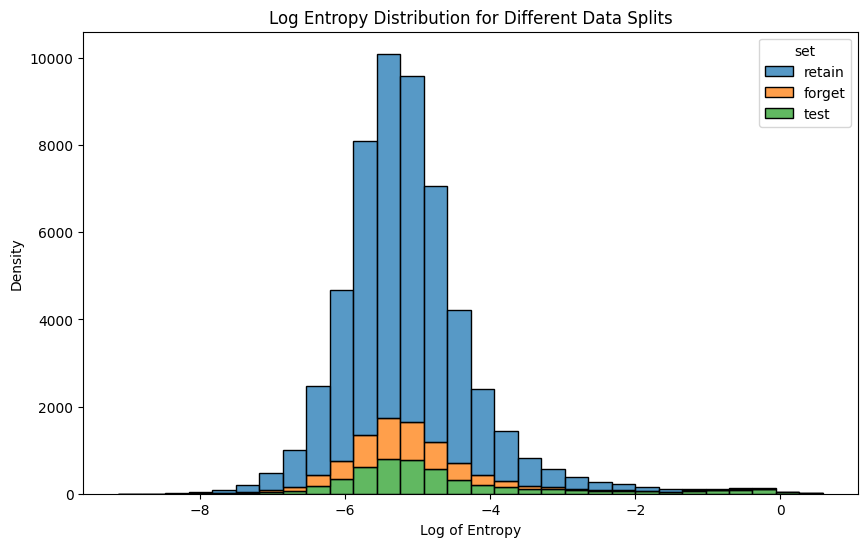

In [53]:
# Create the histogram plot with different colors for each data split
plt.figure(figsize=(10, 6))
sns.histplot(data=data_original, x='log_entropy', hue='set', multiple='stack', kde=False, bins=30)
plt.title('Log Entropy Distribution for Different Data Splits')
plt.xlabel('Log of Entropy')
plt.ylabel('Density')

plt.show()